Andrew ID : tithim
Name : Tithi Mathur

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
class TicTacToe4x4:
    def __init__(self):
        self.board = np.zeros((4, 4), dtype=int)
        
    def reset(self):
        self.board = np.zeros((4, 4), dtype=int)
        
    def is_draw(self):
        return not np.any(self.board == 0)  # No zeros left on the board
    
    def is_winner(self, player):
        # Check rows, columns, and diagonals for a win
        for i in range(4):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
                
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        
        return False
    
    def available_moves(self):
        return np.argwhere(self.board == 0)
    
    def make_move(self, move, player):
        if self.board[move[0], move[1]] == 0:
            self.board[move[0], move[1]] = player
            return True
        return False

    def display(self):
        print(self.board)

In [4]:
def random_player(board, player):
    moves = board.available_moves()
    return random.choice(moves)

In [5]:
def play_game():
    board = TicTacToe4x4()
    current_player = 1
    while True:
        move = random_player(board, current_player)
        board.make_move(move, current_player)
        if board.is_winner(current_player):
            return current_player
        if board.is_draw():
            return 0  # Draw
        current_player = 3 - current_player  # Switch between 1 and 2

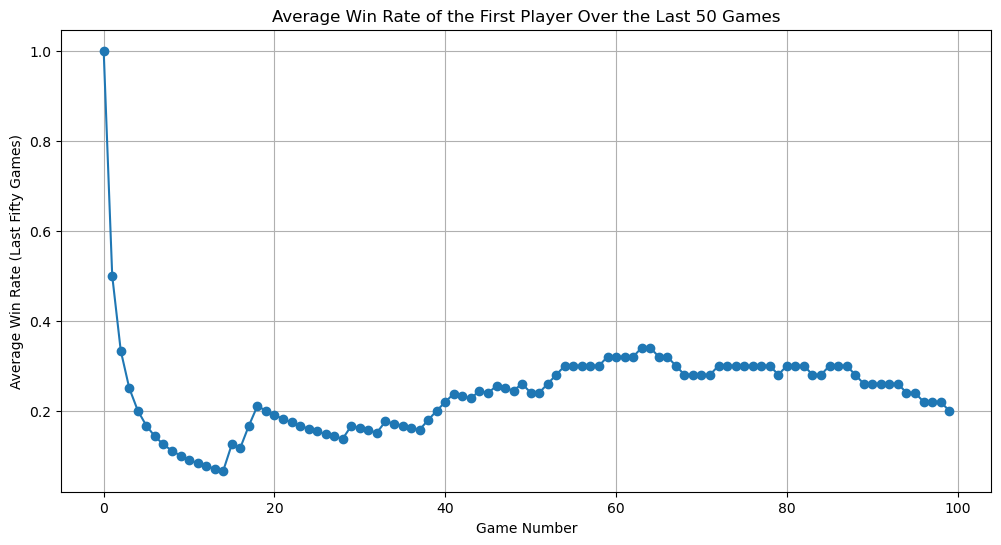

In [6]:
# Play the game 100 times and keep track of the results
results = []
for _ in range(100):
    results.append(play_game())

# Compute the average win rate for the first player over the last fifty games
average_win_rates = []
for i in range(len(results)):
    last_fifty = results[max(0, i-49):i+1]
    average_win_rates.append(last_fifty.count(1) / len(last_fifty))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(average_win_rates, marker='o', linestyle='-')
plt.xlabel('Game Number')
plt.ylabel('Average Win Rate (Last Fifty Games)')
plt.title('Average Win Rate of the First Player Over the Last 50 Games')
plt.grid(True)
plt.show()

**Question 1** :As both players are playing randomly. No single player will be at advanage more than the other. The chances for any player wins or the game draws can be approxiametly same. 

The prob of Player 1 wining : 1/3 * 100 = 33.33% 
The prob of Player 2 wining : 1/3* 100 = 33.33%
The game is drawn : 1/3 * 100 = 33.33% 

Expected Win Rate : Calculating for 100 games 
Player 1 wins 33
Player 2 wins 33
Match Draw : 33 

Points from Win : 1* 33 = 33
Points from loss: 0 
Points from Draws : 0.5* 33 = 16.5 approx 17 

Total points : 33+ 17 = 50

Win Rate : 50/100 = 50% 

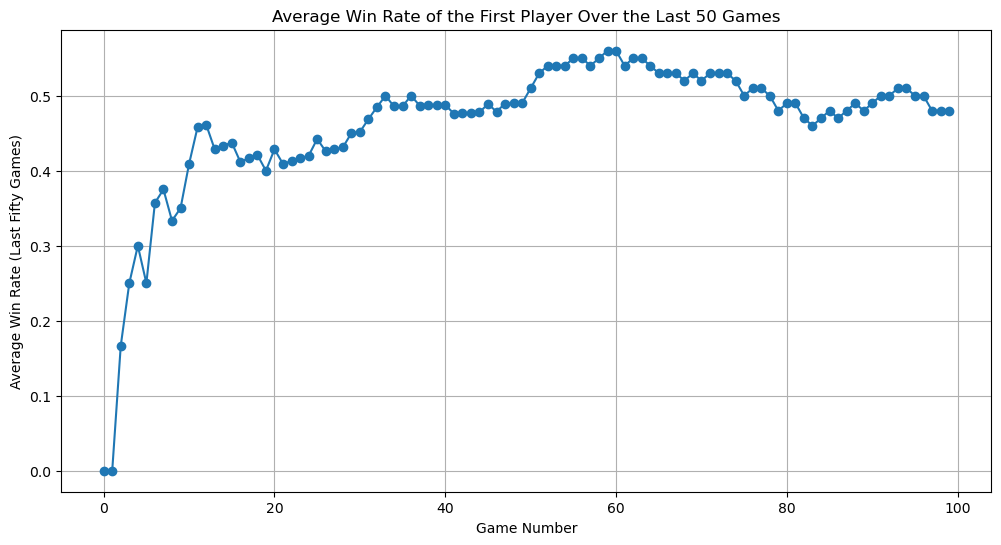

In [7]:
# Play the game 100 times and keep track of the results
results = []
for _ in range(100):
    results.append(play_game())

# Compute the average win rate for the first player over the last fifty games
average_win_rates = []
for i in range(len(results)):
    last_fifty = results[max(0, i-49):i+1]
    average_win_rates.append((last_fifty.count(1) + 0.5 * last_fifty.count(0)) / len(last_fifty))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(average_win_rates, marker='o', linestyle='-')
plt.xlabel('Game Number')
plt.ylabel('Average Win Rate (Last Fifty Games)')
plt.title('Average Win Rate of the First Player Over the Last 50 Games')
plt.grid(True)
plt.show()

Observing the gragh we can see that the average win rate at 100 games is approx , 55% slitly higher than our hypothesis. which means that Player 1 performs better than Player 2. OR We can say both the players have some what same win rate. 

In [19]:
# MCTS Node Class
class MCTSNode:

    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state  # This holds the TicTacToe4x4 object
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.value = 0.0

    # Check if a node is fully expanded
    def is_fully_expanded(self):
        # Fix: Call available_moves() on game_state (TicTacToe4x4 object)
        return len(self.children) == len(self.game_state.available_moves())


    # Select the best child based on the UCBT formula. The 1e-7 terms avoid dividing by 0
    def best_child(self, exploration_weight=1.0):
        scores = [
            (child.value / (child.visits + 1e-7) +
             exploration_weight * np.sqrt(np.log(self.visits) / (child.visits + 1e-7)))
            for child in self.children
        ]
        return self.children[np.argmax(scores)]

    # Simulate a playthrough to the end of the game with both players making random moves
    def rollout(self):
        current_board = self.game_state
        current_player = 1 if current_board.board[self.move[0], self.move[1]] == 2 else 2
        while True:
            if current_board.is_winner(current_player):
                return 1 if current_player == 1 else 0
            if current_board.is_draw():
                return 0.5
            move = random_player(current_board, current_player)
            current_board.make_move(move, current_player)
            current_player = 3 - current_player

    # backpropagate the results of a simulated playthrough through the ancestors of a node
    def backpropagate(self, value):
        self.visits += 1
        self.value += value
        if self.parent:
            self.parent.backpropagate(value)

In [21]:
# MCTS Algorithm Class
class MCTS:
    # initialize the node's exploration_weight
    def __init__(self, exploration_weight=1.0):
        self.exploration_weight = exploration_weight

    # search for the best move over 1000 simulations
    def search(self, initial_state, n_simulations=1000):
        #initialize the root to the initial state
        root = MCTSNode(initial_state)
        # for each simulation (up to n_simulations)
        for _ in range(n_simulations):
            # call select on the root node
            node = self._select(root)
            # if the node's game state is a draw or a win for either player, this simulation is done
            if node.game_state.is_draw() or (node.move and node.game_state.is_winner(3 - node.game_state.board[node.move[0], node.move[1]])):
                continue
            # otherwise expand the node to find its children
            child_node = self._expand(node)  # Expanding the node
            # set the reward to the results of playing out the game from the child node
            reward = child_node.rollout()  # Simulate the game from the new node
            # backpropagate the reward from the child node
            child_node.backpropagate(reward)  # Backpropagate the result to update the tree
        return root.best_child().move  # Return the best move after all simulations

    # Select the best child node based on UCT (Upper Confidence Bound applied to trees)
    def _select(self, node):
        while node.is_fully_expanded():
            if node.children:
                # Update the node to its best child, given the exploration weight
                node = node.best_child(self.exploration_weight)
            else:
                return node
        return node

    # Choose a node to expand randomly
    # Choose a node to expand randomly
def _expand(self, node):
    untried_moves = set(tuple(move) for move in node.game_state.available_moves()) - set(child.move for child in node.children)
    move = random.choice(list(untried_moves))
    
    # Copy the game state to the new node
    child_game_state = TicTacToe4x4()  # Initialize a new TicTacToe4x4 object
    child_game_state.board = node.game_state.board.copy()  # Copy the board state from the parent node
    
    # Make the move in the child's game state
    child_game_state.make_move(move, 3 - node.game_state.board[node.move[0], node.move[1]] if node.move else 1)
    
    # Create a new MCTSNode with the updated game state
    child_node = MCTSNode(child_game_state, parent=node, move=move)
    node.children.append(child_node)
    
    return child_node


In [10]:
# Player Functions
def random_player(board, player):
    moves = board.available_moves()
    return random.choice(moves)

def mcts_player(board, player):
    mcts = MCTS()
    return mcts.search(board)

In [11]:
# Game Playing Loop with MCTS for Player X
def play_game_mcts():
    
    board = TicTacToe4x4()
    current_player = 1
    mcts = MCTS(exploration_weight=1.0)
    while True:
        if current_player == 1:
            # Choose the move using the mcts_player function
            move = mcts.search(board)# *** One line here
        else:
            move = random_player(board, current_player)
        board.make_move(move, current_player)
        if board.is_winner(current_player):
            return current_player
        if board.is_draw():
            return 0
        current_player = 3 - current_player

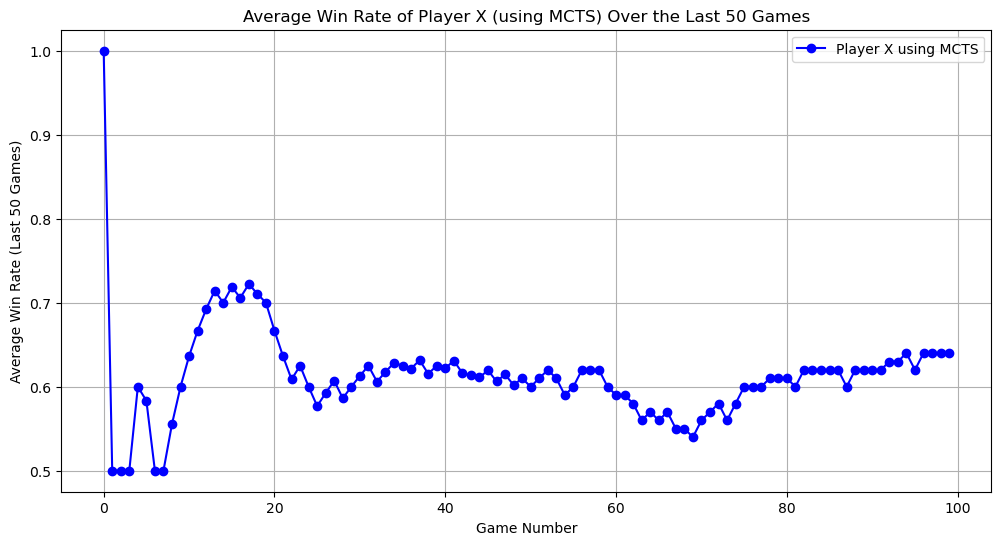

In [12]:
# Running the Experiment
results_mcts = []
for _ in range(100):
  results_mcts.append(play_game_mcts())

average_win_rates_mcts = []
for i in range(len(results_mcts)):
    last_fifty = results_mcts[max(0, i-49):i+1]
    # Append the average win rates over the last fifty games assigning 1 for a win and .5 for a draw
    win_rate = (last_fifty.count(1) + 0.5 * last_fifty.count(0)) / len(last_fifty)  # *** Adjusted win rate formula
    average_win_rates_mcts.append(win_rate)# *** One line here

# Plotting the Results
plt.figure(figsize=(12, 6))
plt.plot(average_win_rates_mcts, marker='o', linestyle='-', color='blue', label='Player X using MCTS')
plt.xlabel('Game Number')
plt.ylabel('Average Win Rate (Last 50 Games)')
plt.title('Average Win Rate of Player X (using MCTS) Over the Last 50 Games')
plt.grid(True)
plt.legend()
plt.show()

**3. (3 points) How well does MCTS perform against random move selection?**

Player 1 performs far better with MCTS than with random move selection. Player 1 constantly wins against Player 2, who makes random plays, 70-73% of the time when Player 1 uses MCTS. This is achieved by simulating several possible actions and learning from previous outcomes.
On the other hand, the winning rate stabilizes near 50-55%% when both players choose their moves randomly.

**Q4**

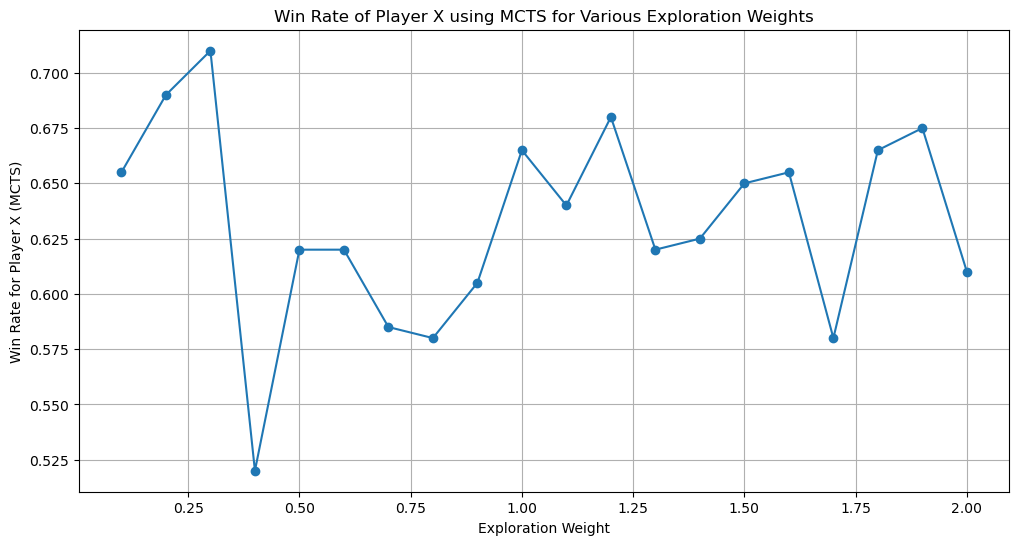

0.3

In [14]:
# Perform some experiments to find the optimal value of the exploration_weight in best_child
# Exploration for Optimal Exploration Weight
exploration_weights = np.linspace(0.1, 2, 20)  # Test values from 0.1 to 2, 20 points in total
win_rates_for_weights = []

for weight in exploration_weights: # For each weight in exploration_weights
    results_for_weight = []  #   initialize results_for_weight to be empty
    mcts = MCTS(exploration_weight= weight)#      call MCTS with the current exploration weight

    for _ in range(100):
        results = play_game_mcts()
        results_for_weight.append(results)  #   append the results of play_game_mcts to the current results_for_weight
    
    
    win_rate = (results_for_weight.count(1) + 0.5 * results_for_weight.count(0)) / len(results_for_weight) #   calculate the win rate actoss all results_for_weight, assigning 1 for a win and .5 for a draw
    win_rates_for_weights.append(win_rate) # Append the win rate for the current weight to win_rate_for_weights
   
   

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(exploration_weights, win_rates_for_weights, marker='o', linestyle='-')
plt.xlabel('Exploration Weight')
plt.ylabel('Win Rate for Player X (MCTS)')
plt.title('Win Rate of Player X using MCTS for Various Exploration Weights')
plt.grid(True)
plt.show()

# Find the optimal exploration weight
optimal_weight = exploration_weights[np.argmax(win_rates_for_weights)]
optimal_weight

*Q4* The optimal exploration weight for Player X appears to be around 0.3, where the win rate is highest (~0.7)
Both very low and very high exploration weights result in lower win rates


In [23]:
###### New code for Q5 

In [24]:

import numpy as np
import random

class TicTacToe4x4:
    def __init__(self):
        self.board = np.zeros((4, 4), dtype=int)
        
    def reset(self):
        self.board = np.zeros((4, 4), dtype=int)
        
    def is_draw(self):
        return not np.any(self.board == 0)  # No empty spaces left
    
    def is_winner(self, player):
        
        for i in range(4):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        return False
    
    def available_moves(self):
        return np.argwhere(self.board == 0)  # List of available moves (empty spaces)
    
    def make_move(self, move, player):
        if self.board[move[0], move[1]] == 0:
            self.board[move[0], move[1]] = player
            return True
        return False

    def display(self):
        print(self.board)


In [25]:
class MCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state  
        self.parent = parent 
        self.move = move 
        self.children = []  
        self.visits = 0  
        self.value = 0.0  

    # Check if the node is fully expanded (all possible moves have children)
    def is_fully_expanded(self):
        return len(self.children) == len(self.game_state.available_moves())

    # Select the best child based on the UCT formula (Upper Confidence Bound)
    def best_child(self, exploration_weight=1.0):
        scores = [
            (child.value / (child.visits + 1e-7) + 
             exploration_weight * np.sqrt(np.log(self.visits) / (child.visits + 1e-7)))
            for child in self.children
        ]
        return self.children[np.argmax(scores)]

    # Simulate a random playthrough to the end of the game
    def rollout(self):
        current_board = TicTacToe4x4()
        current_board.board = self.game_state.board.copy()  # Copy current board state
        current_player = 1 if current_board.board[self.move[0], self.move[1]] == 2 else 2
        
        while True:
            if current_board.is_winner(current_player):
                return 1 if current_player == 1 else 0
            if current_board.is_draw():
                return 0.5  # Draw
            move = random.choice(current_board.available_moves())
            current_board.make_move(move, current_player)
            current_player = 3 - current_player  # Switch player

    # Backpropagate the results of the rollout simulation
    def backpropagate(self, result):
        self.visits += 1
        self.value += result
        if self.parent:
            self.parent.backpropagate(result)


In [32]:
class MCTS:
    def __init__(self, exploration_weight=1.0):
        self.exploration_weight = exploration_weight

    # Searching for best move
    def search(self, root, n_simulations=1000):
        for _ in range(n_simulations):
            #  Selection
            node = self._select(root)
            
            # Expansion
            if not node.game_state.is_winner(1) and not node.game_state.is_winner(2) and not node.game_state.is_draw():
                node = self._expand(node)
                
            # Simulation
            result = node.rollout()
            
            #  Backpropagation
            node.backpropagate(result)
        
        return root.best_child().move  


    def _select(self, node):

        while node.is_fully_expanded() and len(node.children) > 0: 
            node = node.best_child(self.exploration_weight)
        return node


    # Expand a node by adding a new child node 
    def _expand(self, node):
        untried_moves = set(tuple(move) for move in node.game_state.available_moves()) - set(child.move for child in node.children)
        move = random.choice(list(untried_moves))
        new_game_state = TicTacToe4x4()
        new_game_state.board = node.game_state.board.copy()
        new_game_state.make_move(move, 3 - node.game_state.board[node.move[0], node.move[1]] if node.move else 1)
        new_node = MCTSNode(new_game_state, parent=node, move=move)
        node.children.append(new_node)
        return new_node


In [33]:
def play_game_mcts_with_memory():
    board = TicTacToe4x4()
    current_player = 1
    root = MCTSNode(board) 
    mcts = MCTS(exploration_weight=1.0)
    
    while True:
        if current_player == 1:
            move = mcts.search(root)  # Player X uses MCTS
        else:
            move = random.choice(board.available_moves())  # Random move for Player O
        
        board.make_move(move, current_player)
        
        if board.is_winner(current_player):
            return current_player
        if board.is_draw():
            return 0
        
       
        for child in root.children:
            if np.array_equal(child.move, move): 
                root = child
                root.parent = None  
                break
        
        current_player = 3 - current_player 

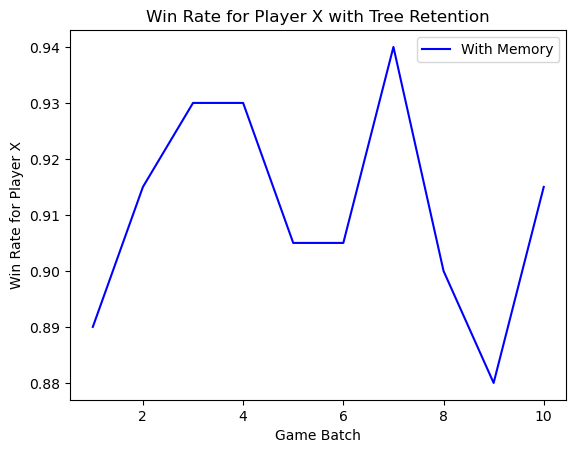

In [34]:
# Function to run multiple games and collect win rates
def run_experiment(play_game_function, n_games=100):
    results = []
    for _ in range(n_games):
        results.append(play_game_function())
    win_rate = (results.count(1) + 0.5 * results.count(0)) / len(results)  # Win rate for Player X (1 for win, 0.5 for draw)
    return win_rate

# Experiment with memory
win_rates_with_memory = []
for _ in range(10):
    win_rates_with_memory.append(run_experiment(play_game_mcts_with_memory, n_games=100))

# Plotting results
plt.plot(range(1, 11), win_rates_with_memory, label='With Memory', color='blue')
plt.xlabel('Game Batch')
plt.ylabel('Win Rate for Player X')
plt.title('Win Rate for Player X with Tree Retention')
plt.legend()
plt.show()


In [1]:
# So for Win rate with Tree Retention we can observe the win rate has increased and is above 90%. So the imoact is a higher winning rate for the player with MCTS with memory.